# Heart predictions with Logistic Regression model

In [1]:
library(tidymodels)
library(tidyverse)
library(themis)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2      ✔ recipes      1.0.4 
✔ dials        1.1.0      ✔ rsample      1.1.1 
✔ dplyr        1.0.10     ✔ tibble       3.1.8 
✔ ggplot2      3.4.0      ✔ tidyr        1.2.1 
✔ infer        1.0.4      ✔ tune         1.0.1 
✔ modeldata    1.0.1      ✔ workflows    1.1.2 
✔ parsnip      1.0.3      ✔ workflowsets 1.0.0 
✔ purrr        1.0.1      ✔ yardstick    1.1.0 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ readr   2.1.3     ✔ forcats 0.5.2
✔ stringr 1.5.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts

## Importing Data

In [2]:
df <- read_csv("/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv")

Rows: 299 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): age, anaemia, creatinine_phosphokinase, diabetes, ejection_fractio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
glimpse(df)

Rows: 299
Columns: 13
$ age                      <dbl> 75, 55, 65, 50, 65, 90, 75, 60, 65, 80, 75, 6…
$ anaemia                  <dbl> 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, …
$ creatinine_phosphokinase <dbl> 582, 7861, 146, 111, 160, 47, 246, 315, 157, …
$ diabetes                 <dbl> 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, …
$ ejection_fraction        <dbl> 20, 38, 20, 20, 20, 40, 15, 60, 65, 35, 38, 2…
$ high_blood_pressure      <dbl> 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, …
$ platelets                <dbl> 265000, 263358, 162000, 210000, 327000, 20400…
$ serum_creatinine         <dbl> 1.90, 1.10, 1.30, 1.90, 2.70, 2.10, 1.20, 1.1…
$ serum_sodium             <dbl> 130, 136, 129, 137, 116, 132, 137, 131, 138, …
$ sex                      <dbl> 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, …
$ smoking                  <dbl> 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, …
$ time                     <dbl> 4, 6, 7, 7, 8, 8, 10, 10, 10, 10, 10, 10, 11,…
$ DEATH_EVENT     

In [4]:
#function to resize plots
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

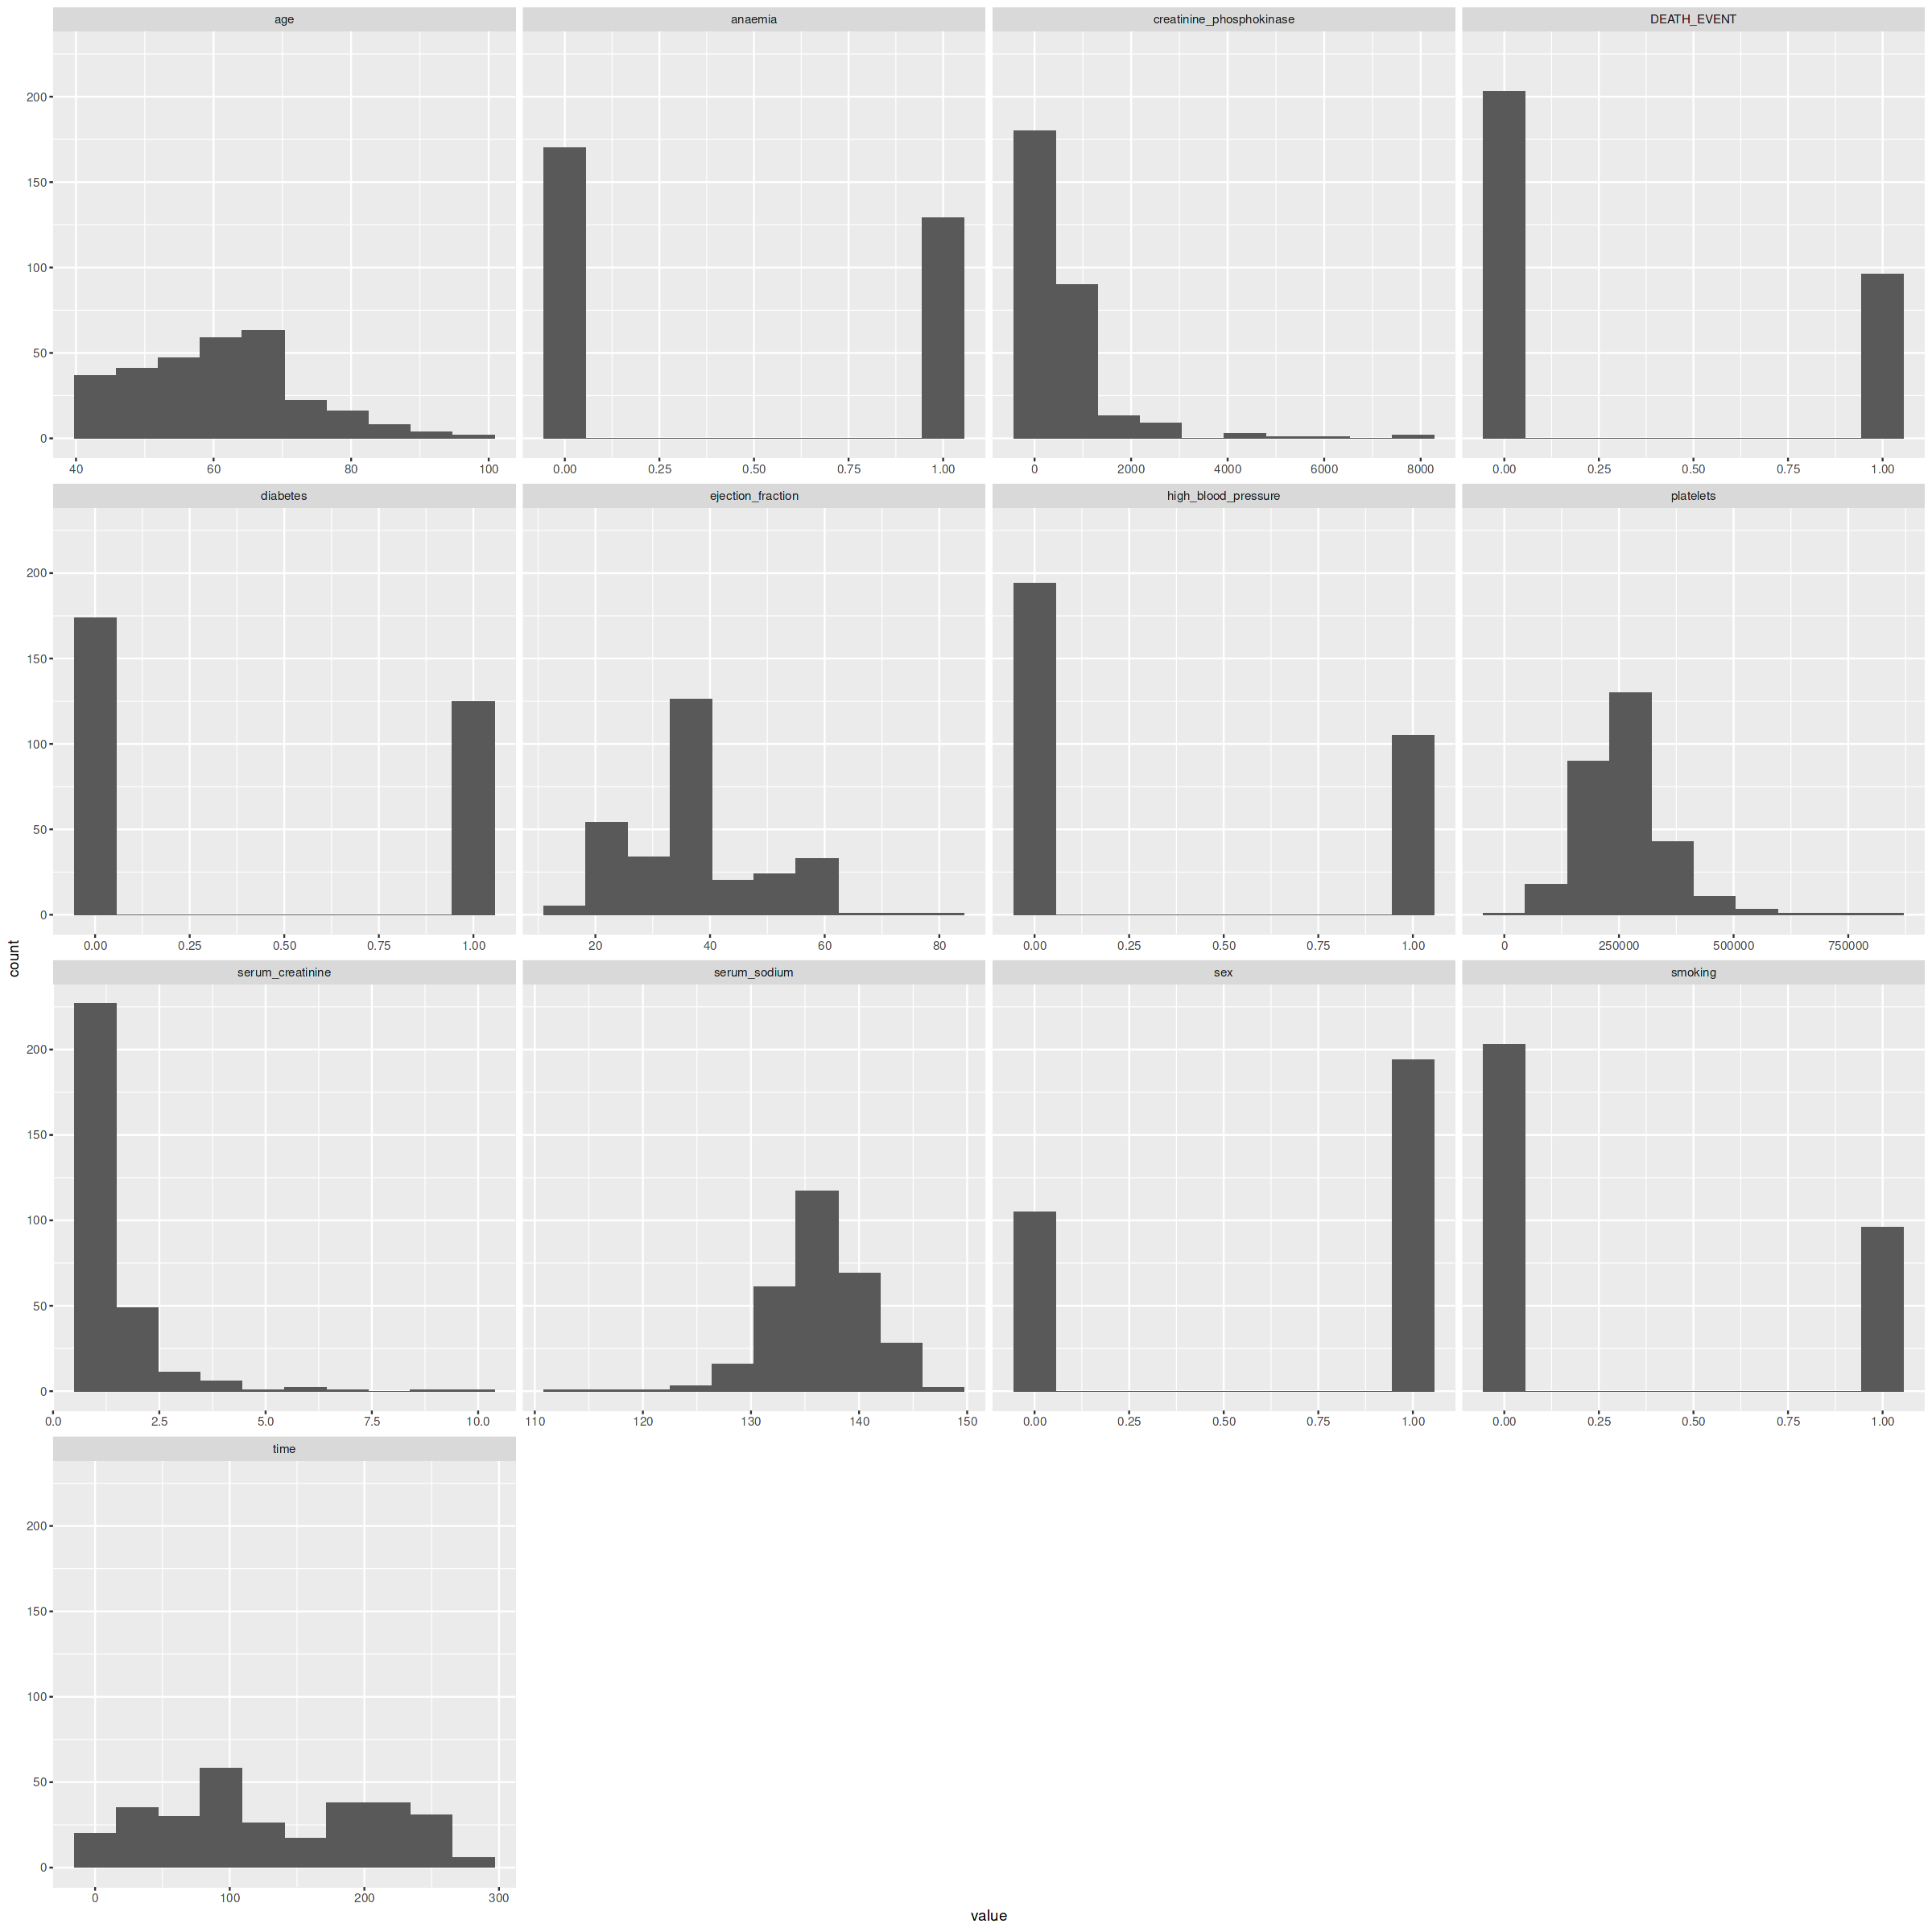

In [5]:
fig(20,20)
ggplot(gather(df), aes(value)) + 
    geom_histogram(bins = 10) + 
    facet_wrap(~key, scales = 'free_x')

In [6]:
df <- df%>%
    mutate(DEATH_EVENT = as.factor(df$DEATH_EVENT))

In [7]:
# Counting nulls

colSums(is.na(df))

age                  anaemia creatinine_phosphokinase 
                       0                        0                        0 
                diabetes        ejection_fraction      high_blood_pressure 
                       0                        0                        0 
               platelets         serum_creatinine             serum_sodium 
                       0                        0                        0 
                     sex                  smoking                     time 
                       0                        0                        0 
             DEATH_EVENT 
                       0

## Data Preprocessing

In [8]:
data_split <- initial_split(df, prop= 0.75)
train_data <- training(data_split)
test_data  <- testing(data_split)
heart_cv <- vfold_cv(train_data, v=10)

In [9]:
model_recipe <- recipe(DEATH_EVENT ~. , data = train_data)%>%
                step_downsample(DEATH_EVENT)%>%
                step_normalize(all_predictors(), - all_outcomes())%>%
                step_zv(all_predictors(), - all_outcomes())

In [10]:
pp_data <- juice(prep(model_recipe))
head(pp_data)

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.21238201,1.037358,-0.415722710,1.2552419,1.6784563,1.2206556,-0.6418908,-0.4929012,0.7557529,-1.3098693,-0.6628416,-0.22326104,0
-0.02167182,-0.957561,-0.490048458,1.2552419,1.6784563,1.2206556,-0.2511817,-0.4929012,0.5312719,0.7583454,-0.6628416,0.07493895,0
-1.34797687,-0.957561,0.004262537,1.2552419,1.2995152,-0.8137704,2.5981357,-0.3972541,-1.0400956,-1.3098693,-0.6628416,1.79931283,0
0.44643584,1.037358,0.061573956,-0.7913481,-0.9741312,-0.8137704,0.3301171,0.6548635,-1.4890577,0.7583454,-0.6628416,-0.04174800,0
0.21238201,-0.957561,0.281864726,1.2552419,-0.2162490,-0.8137704,-0.0667096,-0.3016071,1.2047150,-1.3098693,-0.6628416,1.87710413,0
-1.73806659,-0.957561,-0.436319002,-0.7913481,-0.2162490,-0.8137704,-0.1463574,-0.3016071,-0.1421713,0.7583454,1.4985984,1.30663458,0


## Verifying unbalanced data after downsample

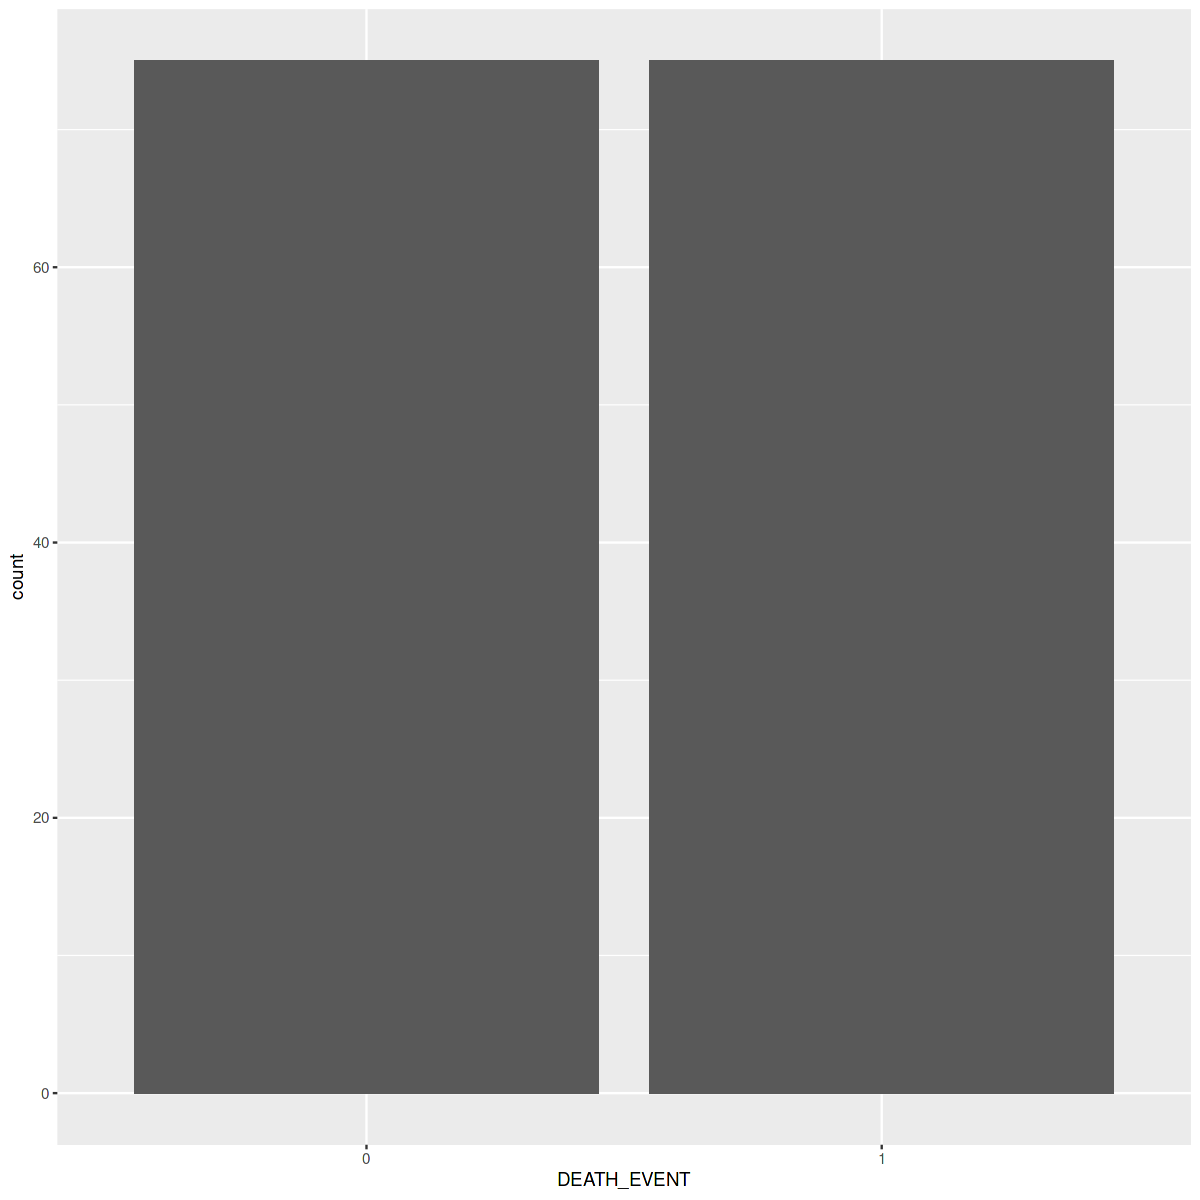

In [11]:
fig(10,10)
ggplot(pp_data, aes(DEATH_EVENT))+
    geom_bar()

## Defining model

In [12]:
model <- logistic_reg(mode = "classification",
               penalty = tune(),
               mixture = tune(),
               engine = "glmnet")

## Creating the workflow

In [13]:
wf <- workflow()%>%
        add_model(model)%>%
        add_recipe(model_recipe)
wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: logistic_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_downsample()
• step_normalize()
• step_zv()

── Model ───────────────────────────────────────────────────────────────────────
Logistic Regression Model Specification (classification)

Main Arguments:
  penalty = tune()
  mixture = tune()

Computational engine: glmnet 


## Tuning Hyperparameters

In [14]:
model_results <- wf%>%
                    tune_grid(resamples = heart_cv,
                             metrics = metric_set(accuracy))

model_results%>%
            collect_metrics()

penalty,mixture,.metric,.estimator,mean,n,std_err,.config
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1.000028e-03,0.08505712,accuracy,binary,0.8035573,10,0.02422810,Preprocessor1_Model01
1.008775e-01,0.18768639,accuracy,binary,0.8083004,10,0.01958860,Preprocessor1_Model02
4.261301e-10,0.27027545,accuracy,binary,0.7990119,10,0.02616710,Preprocessor1_Model03
1.585586e-08,0.39663541,accuracy,binary,0.7990119,10,0.02616710,Preprocessor1_Model04
1.344593e-09,0.43462337,accuracy,binary,0.7990119,10,0.02616710,Preprocessor1_Model05
1.583265e-04,0.59826919,accuracy,binary,0.7990119,10,0.02616710,Preprocessor1_Model06
1.107949e-02,0.69813596,accuracy,binary,0.7859684,10,0.02346717,Preprocessor1_Model07
5.802311e-05,0.74958963,accuracy,binary,0.7990119,10,0.02616710,Preprocessor1_Model08
9.722356e-06,0.88424633,accuracy,binary,0.7990119,10,0.02616710,Preprocessor1_Model09


## Final Hyperparameter

In [15]:
final_param <- model_results%>%
                    select_best(metric="accuracy")

final_wf <- wf%>%
                finalize_workflow(final_param)

final_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: logistic_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_downsample()
• step_normalize()
• step_zv()

── Model ───────────────────────────────────────────────────────────────────────
Logistic Regression Model Specification (classification)

Main Arguments:
  penalty = 0.100877521594004
  mixture = 0.187686386825517

Computational engine: glmnet 


## Last Fit

In [16]:
model_fit <- final_wf%>%
                last_fit(data_split)

## Colecting Predictions

In [17]:
test_performance <- model_fit%>%
                        collect_predictions()
test_performance

id,.pred_0,.pred_1,.row,.pred_class,DEATH_EVENT,.config
<chr>,<dbl>,<dbl>,<int>,<fct>,<fct>,<chr>
train/test split,0.198518927,0.8014811,4,1,1,Preprocessor1_Model1
train/test split,0.034835041,0.9651650,5,1,1,Preprocessor1_Model1
train/test split,0.005491905,0.9945081,10,1,1,Preprocessor1_Model1
train/test split,0.152070286,0.8479297,30,1,1,Preprocessor1_Model1
train/test split,0.486750770,0.5132492,35,1,1,Preprocessor1_Model1
train/test split,0.109930754,0.8900692,36,1,1,Preprocessor1_Model1
train/test split,0.192622742,0.8073773,39,1,0,Preprocessor1_Model1
train/test split,0.263949351,0.7360506,40,1,1,Preprocessor1_Model1
train/test split,0.380799365,0.6192006,43,1,1,Preprocessor1_Model1


## Performance Metrics

In [18]:
model_fit%>%
        collect_metrics()

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.8000000,Preprocessor1_Model1
roc_auc,binary,0.8650794,Preprocessor1_Model1
